# Estimating Energy From Solar Panels Using Gaussian Processes

In this notebook we use the measurment obtained from the dataset described in [A Testbed and an Experimental Public Dataset for Energy-Harvested IoT Solutions](https://www.researchgate.net/publication/337362922_A_Testbed_and_an_Experimental_Public_Dataset_for_Energy-Harvested_IoT_Solutions) and is available for download [here](https://github.com/UCLM-ARCO/energy-harvesting-dataset). In this work, we use a subset of the dataset collected by panels with id Node 13,3 and Node 14,4. Measurements were collected between the 15th and 31st of August 2018. Furthermore, the indexes in the saved .csv files match the indexes in the original dataset and are kept for tractability.




In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import interpolate
import time
#Import the libraries we need for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel
pd.options.display.max_rows = 12 # To limit the number of rows we show with pandas
%matplotlib inline 
# Graphing helper function
def setup_graph(title='', x_label='', y_label='', fig_size=None, fontsize=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if fontsize != None:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)

## Preparing data 

We re-sample the datapoints to ensure the measurmnets are obtained in a five minute intervals. We plot original and the re-sampled dataset!

In [21]:
node13_3 = pd.read_csv('data/node13_3.csv')
node13_4 = pd.read_csv('data/node13_4.csv')

print("The node 13_3 has ", node13_3.size,  " measurments in total!")
print("The node 13_4 has ", node13_4.size,  " measurments in total!")

node13_3.index = pd.to_datetime(node13_3['Date_time'])
node13_4.index = pd.to_datetime(node13_4['Date_time'])

The node 13_3 has  22086  measurments in total!
The node 13_4 has  28674  measurments in total!


new time points: [0.0000e+00 3.0000e+02 6.0000e+02 ... 1.2954e+06 1.2957e+06 1.2960e+06]
original time steps: [  -3483   -2281    -598 ... 1468279 1468639 1468759]
new time points: [0.0000e+00 3.0000e+02 6.0000e+02 ... 1.2954e+06 1.2957e+06 1.2960e+06]
original time steps: [  -3362   -3122   -2762 ... 1467197 1467557 1467798]


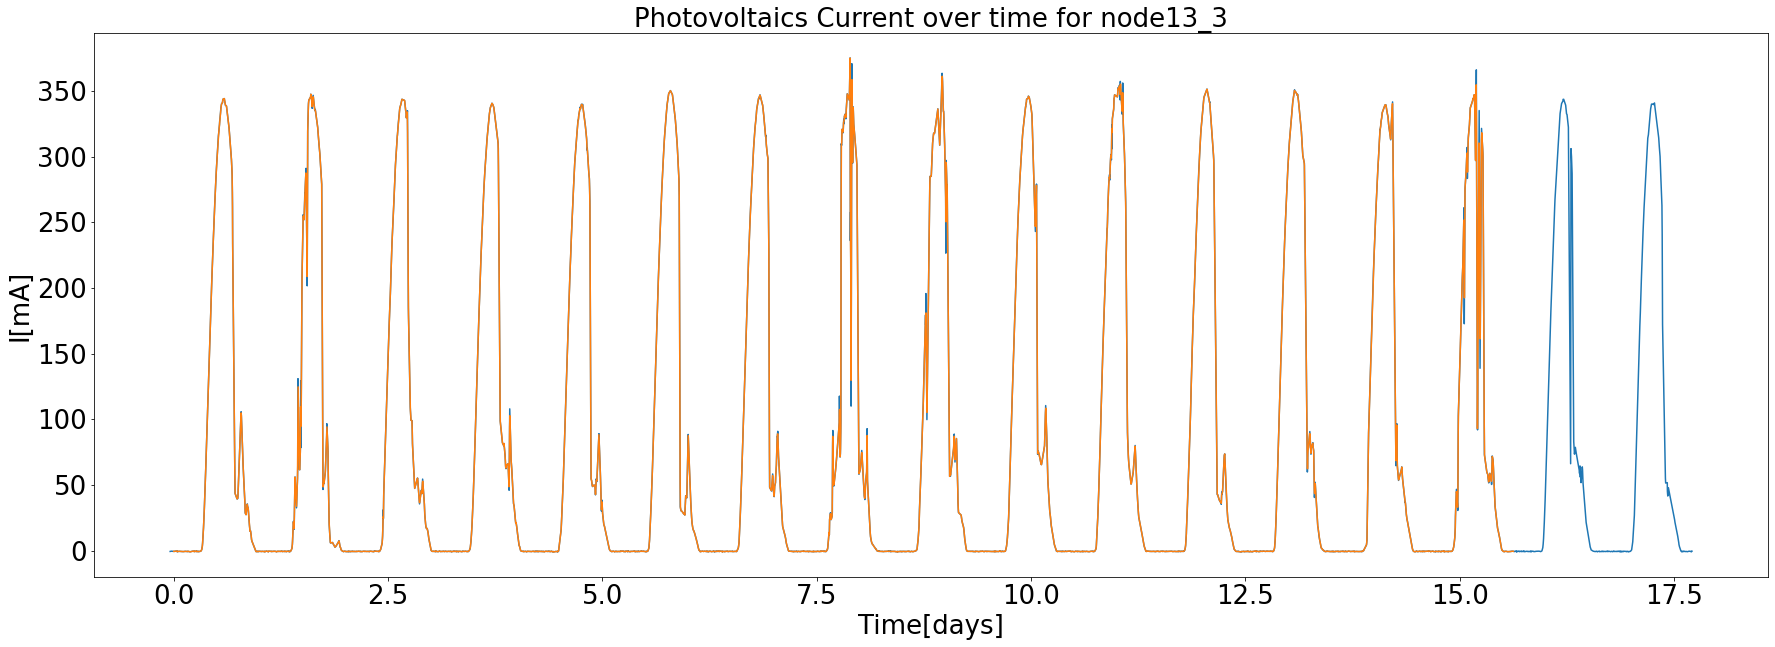

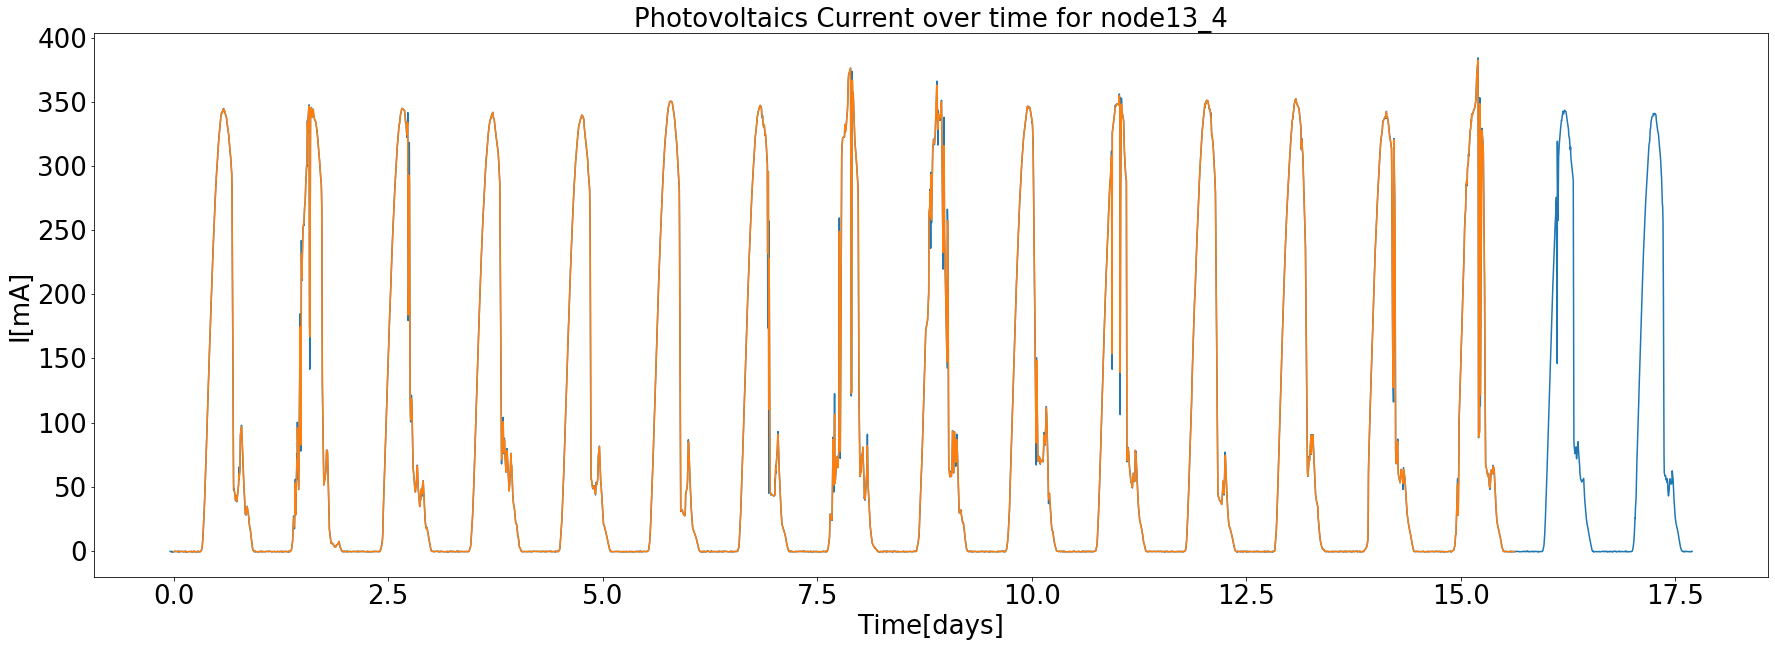

In [38]:
samples_per_hour = 12
samples_per_day = samples_per_hour * 24
samples_num_days = 15
samples_in_total = samples_per_day * samples_num_days

node13_3.name = 'node13_3'
node13_4.name = 'node13_4'

list_of_datasets = [node13_3, node13_4 ]

for dataset in list_of_datasets:

    xnew = np.linspace(0, 86400 * samples_num_days, samples_in_total + 1) # We want a PV current mesumrnet measurment for every minute in 15 days 
    print("new time points:", xnew)
    #make two dataframes for temporal use
    temporal = pd.DataFrame()

    dataset['Delta_time'] = dataset.index -  datetime.datetime(2018, 8, 15, 0, 0)

    time = np.asarray([np.round((x.days * 86400 + x.seconds), 2) for x in dataset['Delta_time'] ])
    print("original time steps:", time)
    pv_current = [float(dataset['PV sc Current'].iloc[0])] + np.asarray([float(x) for x in dataset['PV sc Current'].tolist()])
    wind_speed = [float(dataset['Wind Speed'].iloc[0])] + np.asarray([float(x) for x in dataset['Wind Speed'].tolist()])
    battery_current = [float(dataset['Battery Current'].iloc[0])] +  np.asarray([float(x) for x in dataset['Battery Current'].tolist()])
    battery_voltage =  [float(dataset['Battery Voltage'].iloc[0])] + np.asarray([float(x) for x in dataset['Battery Voltage'].tolist()])
    temperature = [float(dataset['Temperature'].iloc[0])] + np.asarray([float(x) for x in dataset['Temperature'].tolist()])
    humidity = [float(dataset['Humidity'].iloc[0])] + np.asarray([float(x) for x in dataset['Humidity'].tolist()])

    #Do the interpolation
    f_inter = interpolate.interp1d(time, pv_current)
    y_pv = f_inter(xnew)

    #Do the interpolation
    f_inter = interpolate.interp1d(time, wind_speed)
    y_wind = f_inter(xnew)

    f_inter = interpolate.interp1d(time, battery_current)
    y_bat_c = f_inter(xnew)

    f_inter = interpolate.interp1d(time, battery_voltage)
    y_bat_v= f_inter(xnew)

    f_inter = interpolate.interp1d(time, temperature)
    y_tem = f_inter(xnew)

    f_inter = interpolate.interp1d(time, humidity)
    y_hum = f_inter(xnew)


    #Round Results
    y_pv = np.round(y_pv, 2)
    y_wind = np.round(y_wind, 2)
    y_bat_c = np.round(y_bat_c, 2)
    y_bat_v = np.round(y_bat_v, 2)
    y_tem = np.round(y_tem, 2)
    y_hum = np.round(y_hum, 2)


    setup_graph(title='Photovoltaics Current over time for ' + dataset.name, x_label='Time[days]', y_label='I[mA]',fig_size=[30, 10], fontsize=26)
    plt.plot(time/(samples_per_day * 12 * 24), pv_current)
    plt.plot(xnew/(samples_per_day * 12 * 24), y_pv)


    df_inter = pd.DataFrame()
    df_inter['time'] = xnew
    df_inter['photovoltaic_current'] = y_pv
    df_inter['wind_speed'] = y_wind
    df_inter['battery_current'] = y_bat_c
    df_inter['battery_voltage'] = y_bat_v
    df_inter['temperature'] = y_tem
    df_inter['humidity'] = y_hum
    
    df_inter.to_csv('interpolation/'+ dataset.name +'.csv')
    

## Predictions Using Gaussian Processes

In this part of the notebook, we use Gaussian Processes (GP) to make PV current predictions. 

We start by building the kernel we will use!

In [40]:
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=86400, periodicity_bounds=(80000, 90000))

kernel_1  = k0 + k1

gp1 = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

Next, we read the data points we will use for estimations and put in the list

In [45]:
node13_3_inter = pd.read_csv('interpolation/node13_3.csv')
node13_4_inter = pd.read_csv('interpolation/node13_4.csv')

panel1_pv = node13_3_inter['photovoltaic_current'].tolist()
panel2_pv = node13_4_inter['photovoltaic_current'].tolist()


We make predictions using the past 7 days of measurments. The resulting sliding window is size 2016 (12 * 24 * 7). We assume that the assume Photovoltaics (PV) current measurmnet is obtained every five minutes. 

In [ ]:
#Generate predictions for the 16 days of data we have at our disposal
sliding_window = samples_per_day * 7 
normalisation_to_seconds = 300  # To ensure time matches 

X_input_set = np.linspace(0, normalisation_to_seconds * sliding_window,  sliding_window + 1)
X_output_set = np.linspace(normalisation_to_seconds * sliding_window, normalisation_to_seconds * sliding_window + normalisation_to_seconds * sliding_window / 7,  samples_per_day) 
# Put the datapoints in the rigth format
X_input = np.asarray([[x] for x in X_input_set])
X_output = np.asarray([[x] for x in X_output_set])

predicted_values_pv1 = []
time_counts = []

for i in range(16):
    Y_input_set = panel1_pv[i*samples_per_day:i*samples_per_day+sliding_window+1]
    Y_input = np.asarray([[x] for x in Y_input_set])
    #Run the GP process with the new data
    time_start = time.time()
    gp1.fit(X_input, Y_input) 
    Y_pred, Y_std = gp1.predict(X_output, return_std=True)
    Y_pred = [x[0] for x in Y_pred]
    predicted_values_pv1 = predicted_values_pv1 + Y_pred
    time_counts.append(time.time() - time_start)
    #print(np.shape(predicted_values_pv1))


In [ ]:
predicted_values_pv1